In [1]:
from IPython.core.display import HTML
css_file = './custom.css'
HTML(open(css_file, "r").read())

###### Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT License. (c)2015 [David I. Ketcheson](http://davidketcheson.info)

##### Version 0.1 - April 2015

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from JSAnimation import IPython_display

ModuleNotFoundError: No module named 'JSAnimation'

# Pseudospectral collocation methods

Welcome to lesson 2 -- in which we'll learn about the main focus of this course: pseudospectral collocation methods for wave equations.  But first, a bit of review.

## Advection-diffusion (again)

$$
\newcommand{\F}{\mathcal F}
\newcommand{\Finv}{{\mathcal F}^{-1}}
$$

In notebook 1 we solved the scalar, linear 1D evolution equation:

$$u_t + u_x = \epsilon u_{xx}$$

by taking the Fourier transform, which "diagonalizes" this infinite-dimensional dynamical system:

$$\hat{u}_t + i\xi\hat{u} = -\xi^2 \epsilon \hat{u}$$

with solution

$$\hat{u}(t) = e^{(-i \xi - \epsilon \xi^2)t} \hat{u}(0)$$

for each mode.

To construct the full solution, we simply take the inverse Fourier transform.  All together, this algorithm looks like:

$$
u(t) = \Finv \left(D\left[e^{(-i \xi - \epsilon \xi^2)t}\right]\F(u) \right),
$$

where we have written $D[f(\xi)]$ to denote the diagonal matrix whose $(j,j)$ entry is given by $f(\xi_j)$.
In the exact solution, the wavenumbers $\xi$ range from $-\infty$ to $+\infty$ (and $D$ is infinite), but in practice we compute on a finite interval of length $L$ with $m$ collocation points.
The wavenumbers are then given by the formula

\begin{align}
\xi_j & = \frac{2 \pi j}{L} & \text{for } -m/2 \le j < m/2,
\end{align}

although the FFT routine orders them differently.

We can make the algorithm even more explicit by recognizing that the FFT (and its inverse) is a linear map, so it can be represented as a matrix multiplication.  Thus

$$\F(u) = Fu$$

where $F$ is a certain $m \times m$ matrix.  This matrix has a number of interesting properties (see e.g. Trefethen, Ch. 3), but for the moment we are only interested in the fact that it is a linear operator.  We can reverse engineer it by applying $\F$ to the columns of the identity matrix:

In [3]:
def F_matrix(m):
    F = np.zeros((m,m),dtype=complex)
    for j in range(m):
        v = np.zeros(m)
        v[j] = 1.
        F[:,j] = np.fft.fft(v)
    return F

print F_matrix(4)

SyntaxError: invalid syntax (<ipython-input-3-04d23b128dd2>, line 9)

Notice that $F$ is symmetric; this is true for any value of $m$.  Also, $F$ is essentially unitary -- that is, it is possible to choose a normalization such that $F$ is unitary, but the normalization in common use means that $FF^*=mI$ (and $F^{-1}F^{-*} = m^{-1} I$).

We won't work with this matrix in practice since applying it naively is much slower than the FFT.  But it is a useful representation.  Thus we can write our "algorithm" simply as

$$
u(t) = F^{-1} D\left[e^{(-i \xi - \epsilon \xi^2)(t-t_0)}\right] F u(t_0).
$$

Now it is completely clear that we are simply applying a similarity transformation that diagonalizes the dynamics of our system.
We can solve any linear, scalar constant-coefficient 1D evolution equation in similar manner, by simply replacing the argument of $D$.  Note that this algorithm is:

- Exact in time (the only error is due to our initial truncation of the Fourier series by sampling the data at a finite set of points); and
- Unconditionally stable.

Here is the implementation as a reminder.

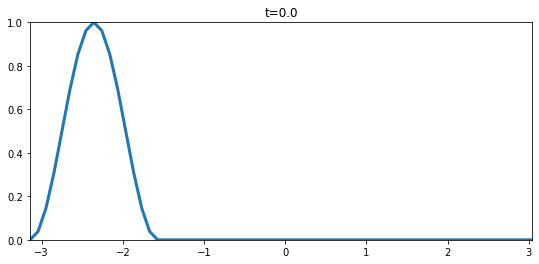

In [4]:
# Spatial grid
m=64                            # Number of grid points in space
L = 2 * np.pi                   # Width of spatial domain
x = np.arange(-m/2,m/2)*(L/m)   # Grid points
dx = x[1]-x[0]                  # Grid spacing

# Temporal grid
tmax=4.0     # Final time
N = 25       # number grid points in time
k = tmax/N   # interval between output times

xi = np.fft.fftfreq(m)*m*2*np.pi/L  # Wavenumber "grid"
# (this is the order in which numpy's FFT gives the frequencies)

# Initial data
u = np.sin(2*x)**2 * (x<-L/4)
uhat0 = np.fft.fft(u)

epsilon=0.01  # Diffusion coefficient
a = 1.0       # Advection coefficient

# Store solutions in a list for plotting later
frames = [u.copy()]

# Now we solve the problem
for n in range(1,N+1):
    t = n*k
    uhat = np.exp(-(1.j*xi*a + epsilon*xi**2)*t) * uhat0
    u = np.real(np.fft.ifft(uhat))
    frames.append(u.copy())
    
# Set up plotting
fig = plt.figure(figsize=(9,4)); axes = fig.add_subplot(111)
line, = axes.plot([],[],lw=3)
axes.set_xlim((x[0],x[-1])); axes.set_ylim((0.,1.))

def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t='+str(i*k))

# Animate the solution
matplotlib.animation.FuncAnimation(fig, plot_frame,
                                   frames=len(frames),
                                   interval=200)

## Variable coefficients

Things become more interesting as soon as we introduce spatially-varying coefficients or nonlinearity.  In either case, the Fourier transform no longer provides a global diagonalization -- instead, it can be thought of as diagonalizing the system at one instant in time.  That means that we will have to discretize in time, and the time step we can use will be restricted by accuracy and (possibly) stability considerations.

Consider now the **variable-coefficient advection equation**

$$ u_t + a(x) u_x = 0.$$

In a purely spectral method, we would take the Fourier transform of this equation and we would need to compute a convolution of $a(x)$ with $u$, which is computationally quite expensive relative to the rest of what we will do.  Specifically, the convolution would require ${\mathcal O}(m^2)$ operations, whereas the FFT requires only ${\mathcal O}(m \log m)$.  To avoid this expense, we use the "pseudospectral" approach: we compute the derivative $u_x$ in the spectral way:

$$ u_x = F^{-1} \left(D\left[i\xi\right] F u\right),$$

and then multiply by $a(x)$ in physical space:

$$ (a(x) u_x)_j = a(x_j) \left(F^{-1}  \left(D\left[i\xi\right] F u\right) \right)_j.$$

Letting
$$
    A = \begin{pmatrix} a(x_1) \\ & a(x_2) \\ & & \ddots \\ & & & a(x_m) \end{pmatrix},
$$
we have the semi-discrete system

$$
U'(t) = -A \Finv \left(D\left[i\xi\right] \F(U)\right).
$$

Next we need to integrate in time.  To choose an appropriate time integrator, we would like to know the spectrum of our semi-discretization.  We can compute it explicitly.

We have a linear ODE system of the form $U'(t) = MU(t)$, where
$$M = -AF^{-1}D[i\xi]F.$$
The code below computes the spectrum of $M$ for a few choices of $a(x)$.

*should add plots of a(x) below*

In [5]:
def plot_spectrum(a,m=64):
    F = F_matrix(m)
    Finv = np.linalg.inv(F)
    L = 2 * np.pi
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    D = np.diag(1.j*xi)
    x = np.arange(-m/2,m/2)*(L/m)
    A = np.diag(a(x))
    M = -np.dot(A,np.dot(Finv,np.dot(D,F)))
    lamda = np.linalg.eigvals(M)
    plt.plot(np.real(lamda),np.imag(lamda),'o')
    plt.axis('equal')

In [6]:
a = lambda x : np.ones(len(x))
plot_spectrum(a,m=32)

NameError: name 'F_matrix' is not defined

In [7]:
a = lambda x : 2 + np.sin(x)
plot_spectrum(a)

NameError: name 'F_matrix' is not defined

We see that the eigenvalues of $M$ are purely imaginary, regardless of the choice of $a(x)$.  In fact we could see this *a priori*, since $M$ is the product of a real diagonal matrix $A$ and a matrix that is similar to $D$.

It is also straightforward to see that the largest eigenvalues of $M$ have magnitude equal to $\max_i |a(x_i)| m/2$.

Thus we should choose a time integrator whose absolute stability region includes part of the imaginary axis -- ideally, a large part of it.  A simple integrator of this type is the explicit midpoint method (also referred to as the *leapfrog* method.  For our problem it amounts to
$$
U^{n+1} = U^{n-1} + 2\Delta t M U^n.
$$
Since this is a 2-step method, we need some other way to take the first step.  For that, we use the explicit Euler method:
$$
U^{n+1} = U^n + \Delta t M U^n.
$$

In [8]:
#a = lambda x : np.ones(len(x))
a = lambda x : 2 + np.sin(x)

F = F_matrix(m)
Finv = np.linalg.inv(F)
L = 2 * np.pi
xi = np.fft.fftfreq(m)*m*2*np.pi/L
D = np.diag(1.j*xi)
x = np.arange(-m/2,m/2)*(L/m)
A = np.diag(a(x))
M = -np.dot(A,np.dot(Finv,np.dot(D,F)))

# Initial data
u = np.sin(2*x)**2 * (x<-L/4)
dx = x[1]-x[0]
dt = 2.0/m/np.max(np.abs(a(x)))/2.
T = 3.
N = int(np.round(T/dt))

frames = [u.copy()]
skip = N/30

# Start with an explicit Euler step
u_new = u + dt*np.dot(M,u)

# Now we solve the problem
for n in range(1,N+1):
    t = n*dt
    u_old = u.copy()
    u = u_new.copy()
    u_new = u_old + 2*dt*np.dot(M,u)
    if ((n % skip) == 0):
        frames.append(u_new.copy())
    
# Set up plotting
fig = plt.figure(figsize=(9,4)); axes = fig.add_subplot(111)
line, = axes.plot([],[],lw=3)
axes.set_xlim((x[0],x[-1])); axes.set_ylim((-0.1,1.1))

def plot_frame(i):
    line.set_data(x,frames[i])
    axes.set_title('t='+str(i*skip*dt))

# Animate the solution
matplotlib.animation.FuncAnimation(fig, plot_frame,
                                   frames=len(frames),
                                   interval=200)

NameError: name 'F_matrix' is not defined

### Exercise: absolute stability
The region of absolute stability for the midpoint method is the interval $S=[-i,i]$.  The numerical solution will be stable only if $\lambda \Delta t \in S$ for all eigenvalues $\lambda$ of $M$.  

Determine the maximum stable step size.

What happens if you take a step size larger than this value?

Now, in addition to truncating the Fourier series of the initial condition, we are truncating the Taylor series of the evolution in time.  This leads to truncation error that accumulates, leading to a solution that is less accurate as time progresses.  Set the $\Delta t$ equal to the largest stable step size and notice the oscillations that appear in front of the pulse as it propagates.

Try reducing the size of $\Delta t$ to decrease the amount of truncation error.

Try some different velocity functions $a(x)$.